### **IMPORT LIBRARY**

In [1]:
#import os libs
import os
from PIL import Image

#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets


#Visual
from matplotlib.image import imread

#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



#Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.listdir('../Batik2/train')

['Kawung',
 'Mega mendung',
 'Parang',
 'Sidoluhur',
 'Sinom Parijotho Salak',
 'Truntum',
 'Tumpal']

### **Review Dataset**

In [2]:
def load_data(folder_path):
    images = []
    labels = []
    folders = os.listdir(folder_path)
    for folder in folders:
        folder_dir = os.path.join(folder_path, folder)
        for image_file in os.listdir(folder_dir):
            image_path = os.path.join(folder_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            image = np.asarray(image.resize((224, 224)))
            images.append(image)
            labels.append(folder)
    return images, labels

def show_image(images, labels, index):
    plt.figure(figsize=(5, 5))
    plt.imshow(images[index])
    plt.title(f"Kelas: {labels[index]}")
    plt.axis('off')
    plt.show()

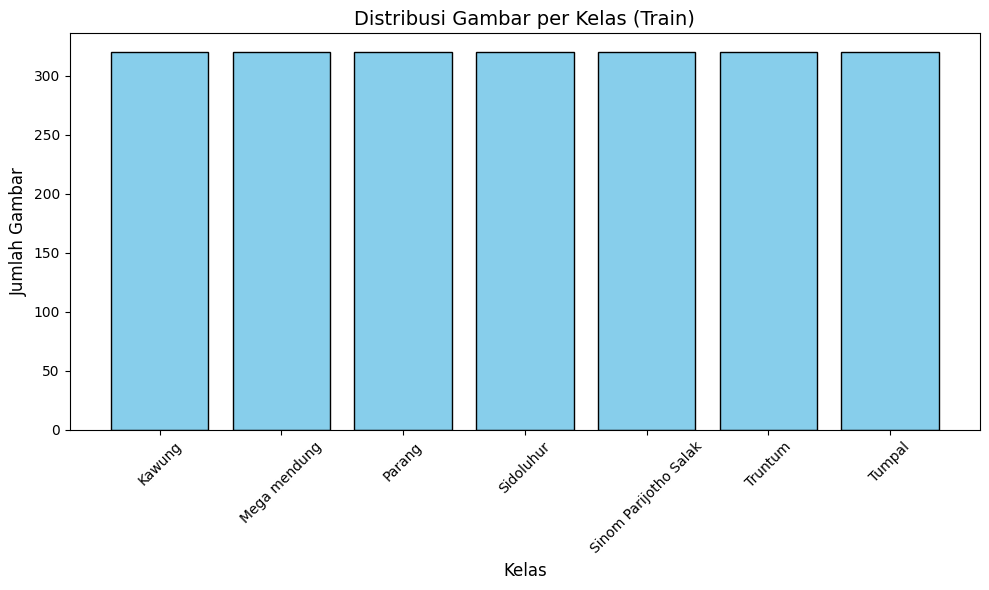

In [4]:
# Re-import necessary libraries after environment reset
import os
import matplotlib.pyplot as plt

# Fungsi untuk menghitung jumlah gambar di setiap folder
def count_images_in_folders(folder_path):
    counts = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            counts[subfolder] = len([
                file for file in os.listdir(subfolder_path)
                if os.path.isfile(os.path.join(subfolder_path, file)) and file.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
    return counts

# Path folder train
train_folder = '../Batik2/train/'

# Hitung jumlah gambar per kelas
train_image_counts = count_images_in_folders(train_folder)

# Visualisasi menggunakan diagram batang
classes = list(train_image_counts.keys())
counts = list(train_image_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.title('Distribusi Gambar per Kelas (Train)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


In [5]:
# Load data dari folder train, valid, dan test
train_images, train_labels = load_data('../Batik2/train/')
test_images, test_labels = load_data('../Batik2/test/')

In [6]:
# Fungsi untuk menampilkan 3 kolom gambar
def show_images(train_index, test_index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot Train Image
    axes[0].imshow(train_images[train_index])
    axes[0].set_title(f"Train\nKelas: {train_labels[train_index]}")
    axes[0].axis('off')
    
    # Plot Test Image
    axes[1].imshow(test_images[test_index])
    axes[1].set_title(f"Test\nKelas: {test_labels[test_index]}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Widget interaktif untuk mengatur indeks gambar
interact(
    show_images,
    train_index=widgets.IntSlider(min=0, max=len(train_images)-1, step=1, value=0, description='Train Index'),
    test_index=widgets.IntSlider(min=0, max=len(test_images)-1, step=1, value=0, description='Test Index')
)

interactive(children=(IntSlider(value=0, description='Train Index', max=2239), IntSlider(value=0, description=…

<function __main__.show_images(train_index, test_index)>

In [7]:
images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
print('Data Training :',images.shape)
print(train_labels.shape)

Data Training : (2240, 224, 224, 3)
(2240,)


In [9]:
def show_image_by_class(images, labels, target_class, pixel_coord=None):
    """
    Menampilkan gambar berdasarkan kelas tertentu dan menampilkan RGB pada koordinat pixel tertentu.
    
    Parameters:
    - images: Daftar gambar (numpy array).
    - labels: Daftar label untuk setiap gambar.
    - target_class: Nama kelas target (string).
    - pixel_coord: Tuple (x, y) untuk koordinat pixel. Default adalah None.
    """
    # Cari indeks gambar dengan kelas yang diminta
    indices = [i for i, label in enumerate(labels) if label == target_class]
    
    if not indices:
        print(f"Tidak ada gambar dengan kelas '{target_class}'.")
        return
    
    # Ambil satu gambar pertama dari kelas yang sesuai
    idx = indices[0]
    image = images[idx]
    
    # Tampilkan gambar
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Kelas: {labels[idx]}")
    plt.axis('off')
    
    # Jika pixel_coord diberikan, tampilkan RGB pada koordinat tersebut
    if pixel_coord:
        x, y = pixel_coord
        rgb_value = image[y, x]  # Perhatikan bahwa y adalah baris dan x adalah kolom
        print(f"RGB pada koordinat {pixel_coord}: {rgb_value}")
    
    plt.show()


RGB pada koordinat (223, 223): [ 91  67 118]


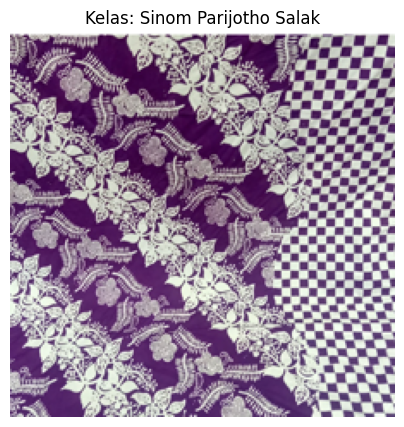

In [10]:
# Tampilkan gambar dari kelas "Sidoluhur" dengan RGB di pixel (100, 100)
show_image_by_class(images, train_labels, target_class="Sinom Parijotho Salak", pixel_coord=(223, 223))

### **PRE-PROCESSING**

#### **SPLIT DATA dan AUGMENTASI**

Dataset dibagi menjadi 2 bagian yaitu training dan testing. Pada bagian training diisi oleh folder Train dan Valid yang akan di split data masing-masing 80:20 untuk menghasilkan model pelatihan. Sedangkan pada bagian testing terdapat oleh folder Test diisi gambar baru yang belum ada pada bagian training untuk mengevaluasi model pelatihan. 

In [ ]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Direktori dataset
DATASET_DIR = "../Batik2/train"  # Sesuaikan dengan lokasi dataset

# Image Augmentation untuk kelas minoritas
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 1. Hitung jumlah gambar per kelas
class_counts = {cls: len(os.listdir(os.path.join(DATASET_DIR, cls))) for cls in os.listdir(DATASET_DIR)}
max_samples = max(class_counts.values())  # Ambil jumlah terbesar sebagai patokan

print("Jumlah gambar awal per kelas:", class_counts)

# 2. Tambah gambar untuk kelas minoritas (Oversampling dengan Augmentasi)
def augment_images(class_dir, target_count):
    images = os.listdir(class_dir)
    current_count = len(images)

    while current_count < target_count:
        selected_images = random.sample(images, min(len(images), target_count - current_count))  # Ambil beberapa gambar random
        
        for img_name in selected_images:
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_format='jpeg'):
                current_count += 1
                if current_count >= target_count:
                    break

# 3. Hapus gambar untuk kelas mayoritas (Undersampling)
def undersample_images(class_dir, target_count):
    images = os.listdir(class_dir)
    if len(images) > target_count:
        images_to_remove = random.sample(images, len(images) - target_count)
        for img in images_to_remove:
            os.remove(os.path.join(class_dir, img))

# 4. Eksekusi balancing dataset
for cls, count in class_counts.items():
    class_dir = os.path.join(DATASET_DIR, cls)
    if count < max_samples:
        print(f"Menambah gambar untuk kelas {cls} dari {count} ke {max_samples}...")
        augment_images(class_dir, max_samples)
    elif count > max_samples:
        print(f"Menghapus gambar untuk kelas {cls} dari {count} ke {max_samples}...")
        undersample_images(class_dir, max_samples)

print("Balancing dataset selesai!")


Jumlah gambar awal per kelas: {'Kawung': 288, 'Mega mendung': 320, 'Parang': 269, 'Sidoluhur': 102, 'Sinom Parijotho Salak': 90, 'Truntum': 212, 'Tumpal': 107}
Menambah gambar untuk kelas Kawung dari 288 ke 320...
Menambah gambar untuk kelas Parang dari 269 ke 320...
Menambah gambar untuk kelas Sidoluhur dari 102 ke 320...
Menambah gambar untuk kelas Sinom Parijotho Salak dari 90 ke 320...
Menambah gambar untuk kelas Truntum dari 212 ke 320...
Menambah gambar untuk kelas Tumpal dari 107 ke 320...
Balancing dataset selesai!


In [3]:
# # Fungsi untuk mengubah gambar ke grayscale
# def convert_to_grayscale(image):
#     # Pastikan gambar dalam format tensor
#     image = tf.image.rgb_to_grayscale(image)  # Konversi ke grayscale
#     image = tf.image.grayscale_to_rgb(image)  # Kembali ke 3 kanal untuk kompatibilitas model
#     return image

# Bagian Training terdapat train dan valid 
train_val_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalisasi nilai piksel ke dalam rentang 0-1
    rotation_range=10,          # Rotasi gambar secara acak
    width_shift_range=0.10,     # Pergeseran horizontal
    height_shift_range=0.10,    # Pergeseran vertikal
    zoom_range=0.2,             # Zoom gambar secara acak
    horizontal_flip=True,       # Membalik gambar secara horizontal
    vertical_flip=True,
    validation_split=0.2,       # Membagi data menjadi train dan validasi
)

# Load gambar dari folder dengan pembagian otomatis
train_generator = train_val_datagen.flow_from_directory(
    '../Batik2/train',             
    target_size=(224, 224),      
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    subset='training'  # Subset untuk data training
)

val_generator = train_val_datagen.flow_from_directory(
    '../Batik2/train',              
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  
    subset='validation'  # Subset untuk data validasi
)

# Bagian Testing terdapat variabel test
test_datagen = ImageDataGenerator(
    rescale=1.0/255
    )

test_generator = test_datagen.flow_from_directory(
    '../Batik2/test',              
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1792 images belonging to 7 classes.
Found 448 images belonging to 7 classes.
Found 130 images belonging to 7 classes.


array([0.9568628, 0.7294118, 0.4784314], dtype=float32)

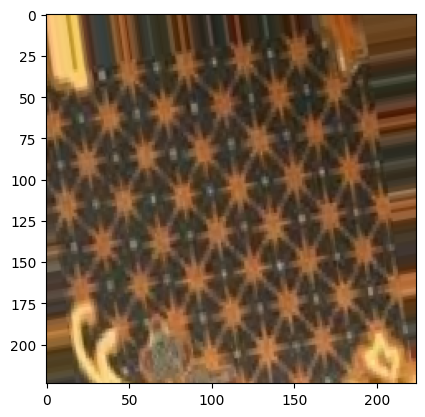

In [4]:
image = next(train_generator)
plt.imshow(image[0][1])  # Menampilkan gambar
image[0][1][2][0]

In [5]:
len(train_generator)

56

In [6]:
len(test_generator)

5

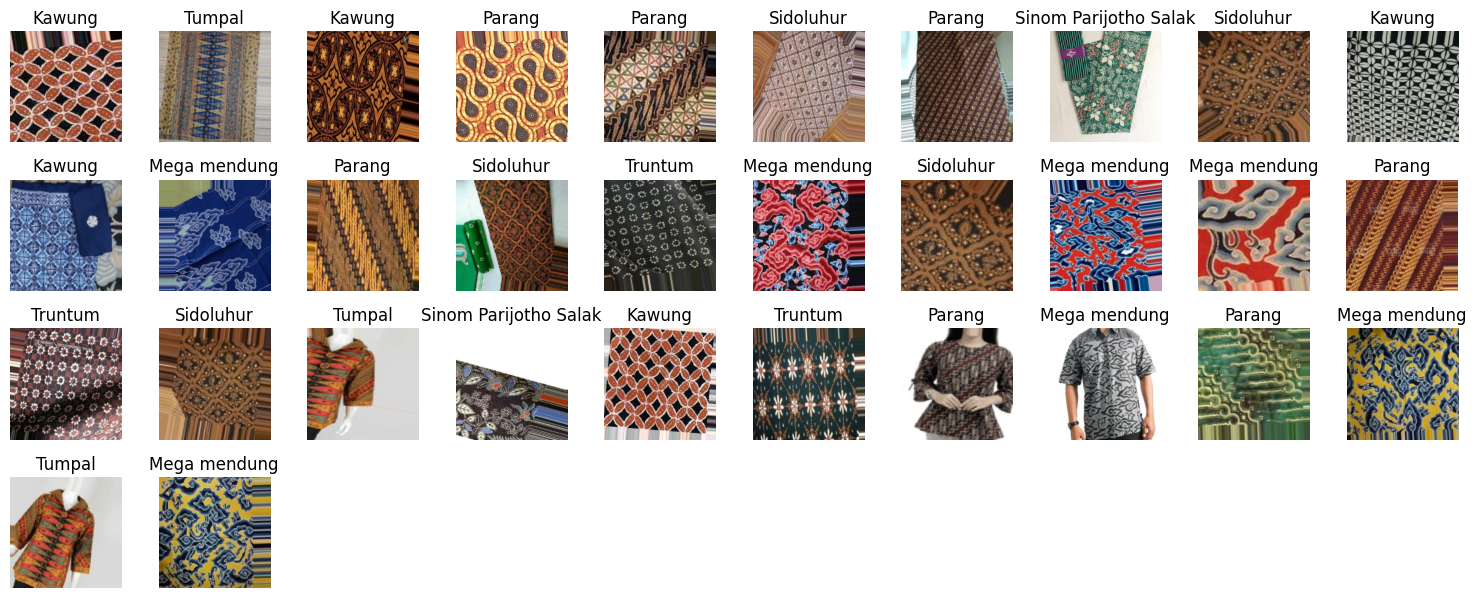

In [7]:
# Ambil satu batch gambar dan label dari train_generator
images, labels = next(train_generator)

# Fungsi untuk menampilkan gambar dari batch
def plot_augmented_images(images, labels, class_indices, num_images=9):
    # Buat dictionary mapping dari class_indices
    class_map = {v: k for k, v in class_indices.items()}
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i])  # Menampilkan gambar
        plt.title(class_map[labels[i].argmax()])  # Menampilkan label
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan gambar augmentasi
plot_augmented_images(images, labels, train_generator.class_indices, num_images=32)


### **PEMBUATAN PELATIHAN MODEL**

#### *Arsitektur MobVnet*

In [8]:
mobnetV2 = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet',include_top=False)

for layer in mobnetV2.layers:
    layer.trainable = False

In [9]:
x1 = layers.Flatten()(mobnetV2.output)
x1 = layers.Dropout(0.5)(x1)
x2 = layers.Dense(7,activation='softmax')(x1)

In [10]:
model = Model(inputs=mobnetV2.input,outputs=x2)

In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time
        hours, rem = divmod(self.total_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Total training time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")


time_callback = TimeHistory()

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import time

# buat variabel model check point dan callbacks
model_checkpoint = ModelCheckpoint("models/my_model_{epoch:03d}_{val_accuracy:.4f}.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
time_callback = TimeHistory() #Callback()  # or define your custom callback

#penggunaan early stoping dan learning rate
early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)


In [14]:
history = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[model_checkpoint, time_callback, early_stopping,reduce_lr])

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 2.1974 - accuracy: 0.7400
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to models\my_model_001_0.8571.h5
56/56 [==============================] - 52s 881ms/step - loss: 2.1974 - accuracy: 0.7400 - val_loss: 1.1248 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 1.1438 - accuracy: 0.8627
Epoch 2: val_accuracy did not improve from 0.85714
56/56 [==============================] - 50s 887ms/step - loss: 1.1438 - accuracy: 0.8627 - val_loss: 1.5287 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 1.1365 - accuracy: 0.8683
Epoch 3: val_accuracy did not improve from 0.85714
56/56 [==============================] - 49s 878ms/step - loss: 1.1365 - accuracy: 0.8683 - val_loss: 1.3089 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.9997 - a

In [15]:
# Menyimpan Model ke folder tujuan
model.save('../models/model_MobVnet2_9/03/2025.h5')

In [16]:
from tensorflow.keras.models import load_model

# load model yang telah disimpan
model = load_model('../models/model_MobVnet2_9/03/2025.h5')

#### Grafik history pelatihan model

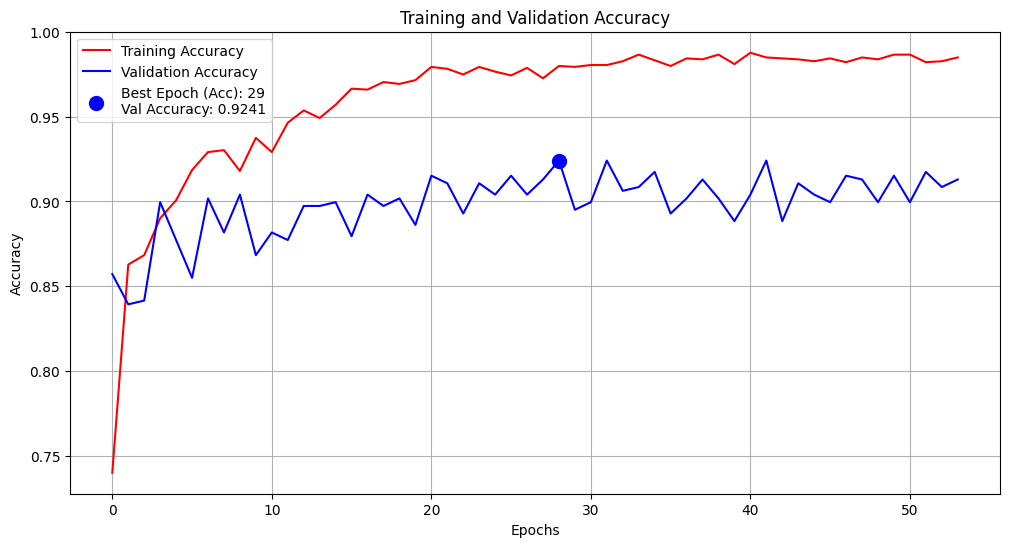

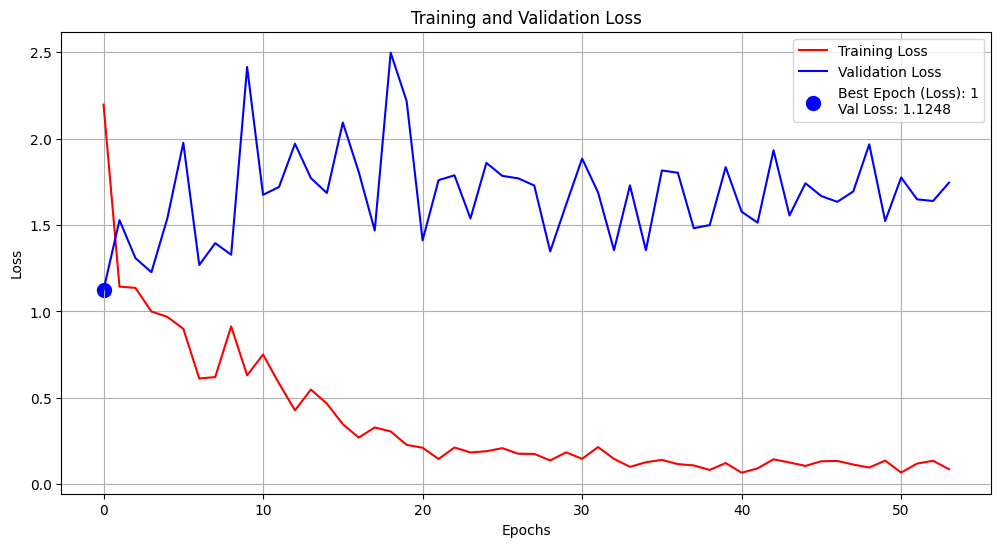

In [17]:
import matplotlib.pyplot as plt

# Mengambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Menentukan epoch terbaik berdasarkan validation accuracy dan validation loss
best_epoch_acc = val_acc.index(max(val_acc))
best_epoch_loss = val_loss.index(min(val_loss))

# Plot akurasi
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.scatter(best_epoch_acc, val_acc[best_epoch_acc], color='blue', marker='o', s=100,
            label=f"Best Epoch (Acc): {best_epoch_acc+1}\nVal Accuracy: {val_acc[best_epoch_acc]:.4f}")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.scatter(best_epoch_loss, val_loss[best_epoch_loss], color='blue', marker='o', s=100,
            label=f"Best Epoch (Loss): {best_epoch_loss+1}\nVal Loss: {val_loss[best_epoch_loss]:.4f}")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [19]:
total_params = 2697031
trainable_params = 439047 
non_trainable_params = 2257984 

# Menggunakan format() atau f-string untuk menambahkan titik pemisah ribuan
print(f"Total params: {total_params:,}".replace(",", "."))
print(f"Trainable params: {trainable_params:,}".replace(",", "."))
print(f"Non-trainable params: {non_trainable_params:,}".replace(",", "."))


Total params: 2.697.031
Trainable params: 439.047
Non-trainable params: 2.257.984


In [20]:
print(f"Jumlah layer dalam model: {len(model.layers)}")

Jumlah layer dalam model: 157


### Evaluasi Model 

In [21]:
eval_result = model.evaluate(val_generator)

test_loss = round(eval_result[0], 2)
test_accuracy = round(eval_result[1], 2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100} %")

14/14 [==============================] - 11s 665ms/step - loss: 1.4315 - accuracy: 0.9241
Test Loss: 1.43
Test Accuracy: 92.0 %


In [22]:
eval_result = model.evaluate(test_generator)

test_loss = round(eval_result[0], 2)
test_accuracy = round(eval_result[1], 2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100} %")

5/5 [==============================] - 3s 541ms/step - loss: 1.3334 - accuracy: 0.9077
Test Loss: 1.33
Test Accuracy: 91.0 %


#### Evaluate Validasi Training

In [23]:
# 1. Mendapatkan label sebenarnya (y_true) dari val_generator
y_true = val_generator.classes

# 2. Mendapatkan prediksi (y_pred) dari model
y_pred_probabilities = model.predict(val_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# 3. Mengambil urutan kelas secara otomatis
class_indices = val_generator.class_indices
classes = list(class_indices.keys())  # Ambil nama kelas dalam urutan yang benar

14/14 [==============================] - 10s 666ms/step


<Figure size 1600x800 with 0 Axes>

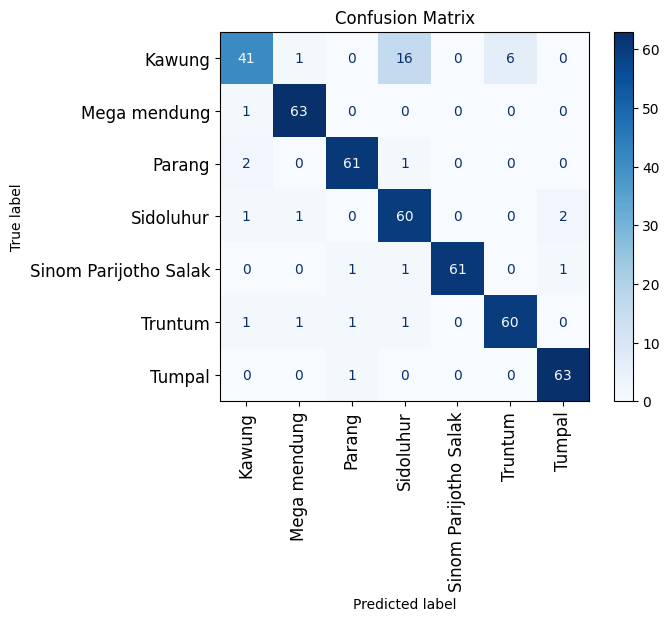

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
plt.figure(figsize=(16, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur ukuran font label untuk axis x dan y
plt.xticks(fontsize=12, rotation=90)  # Atur ukuran font pada sumbu x
plt.yticks(fontsize=12)  # Atur ukuran font pada sumbu y

plt.title("Confusion Matrix")
plt.show()


In [25]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(y_true, y_pred, target_names=classes))


                       precision    recall  f1-score   support

               Kawung       0.89      0.64      0.75        64
         Mega mendung       0.95      0.98      0.97        64
               Parang       0.95      0.95      0.95        64
            Sidoluhur       0.76      0.94      0.84        64
Sinom Parijotho Salak       1.00      0.95      0.98        64
              Truntum       0.91      0.94      0.92        64
               Tumpal       0.95      0.98      0.97        64

             accuracy                           0.91       448
            macro avg       0.92      0.91      0.91       448
         weighted avg       0.92      0.91      0.91       448



In [26]:
classes

['Kawung',
 'Mega mendung',
 'Parang',
 'Sidoluhur',
 'Sinom Parijotho Salak',
 'Truntum',
 'Tumpal']

In [27]:
len(test_generator)

5

#### Evaluate Testing Model

In [28]:
# 1. Mendapatkan label sebenarnya (y_true) dari val_generator
y_true = test_generator.classes

# 2. Mendapatkan prediksi (y_pred) dari model
y_pred_probabilities = model.predict(test_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# 3. Mengambil urutan kelas secara otomatis
class_indices = val_generator.class_indices
classes = list(class_indices.keys())  # Ambil nama kelas dalam urutan yang benar

5/5 [==============================] - 3s 461ms/step


<Figure size 1600x800 with 0 Axes>

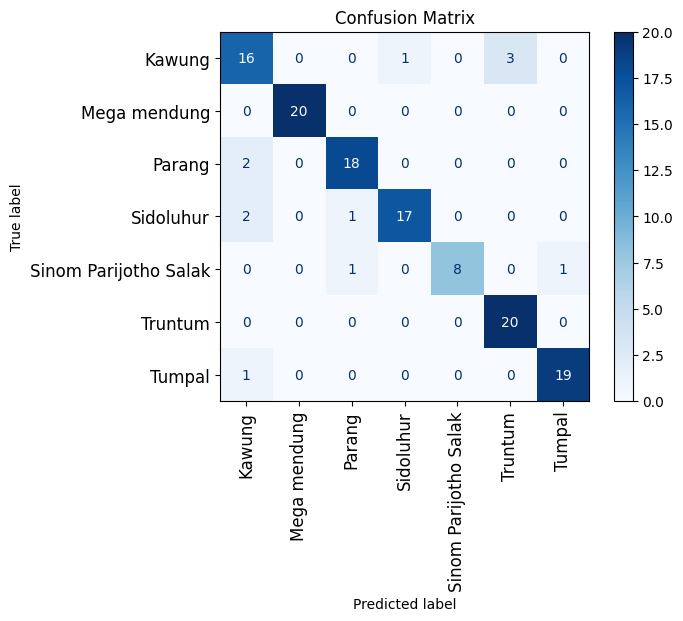

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
plt.figure(figsize=(16, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur ukuran font label untuk axis x dan y
plt.xticks(fontsize=12, rotation=90)  # Atur ukuran font pada sumbu x
plt.yticks(fontsize=12)  # Atur ukuran font pada sumbu y

plt.title("Confusion Matrix")
plt.show()


In [30]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(y_true, y_pred, target_names=classes))


                       precision    recall  f1-score   support

               Kawung       0.76      0.80      0.78        20
         Mega mendung       1.00      1.00      1.00        20
               Parang       0.90      0.90      0.90        20
            Sidoluhur       0.94      0.85      0.89        20
Sinom Parijotho Salak       1.00      0.80      0.89        10
              Truntum       0.87      1.00      0.93        20
               Tumpal       0.95      0.95      0.95        20

             accuracy                           0.91       130
            macro avg       0.92      0.90      0.91       130
         weighted avg       0.91      0.91      0.91       130



# Pengujian Lain-lain

# Pengujian Lain-lain

In [31]:
def get_all_batches(generator):
    x_all, y_all = [], []
    
    # Iterasi melalui generator
    for _ in range(len(generator)):  # Panjang generator menunjukkan jumlah batch
        x_batch, y_batch = next(generator)  # Ambil satu batch
        x_all.append(x_batch)  # Tambahkan gambar ke list
        y_all.append(y_batch)  # Tambahkan label ke list
    
    # Gabungkan semua batch menjadi array
    x_all = np.concatenate(x_all)
    y_all = np.concatenate(y_all)
    
    return x_all, y_all

# Pastikan shuffle=False untuk konsistensi
val_generator.shuffle = False

# Ambil seluruh batch dari val_generator
x_all, y_all = get_all_batches(val_generator)

14/14 [==============================] - 8s 501ms/step


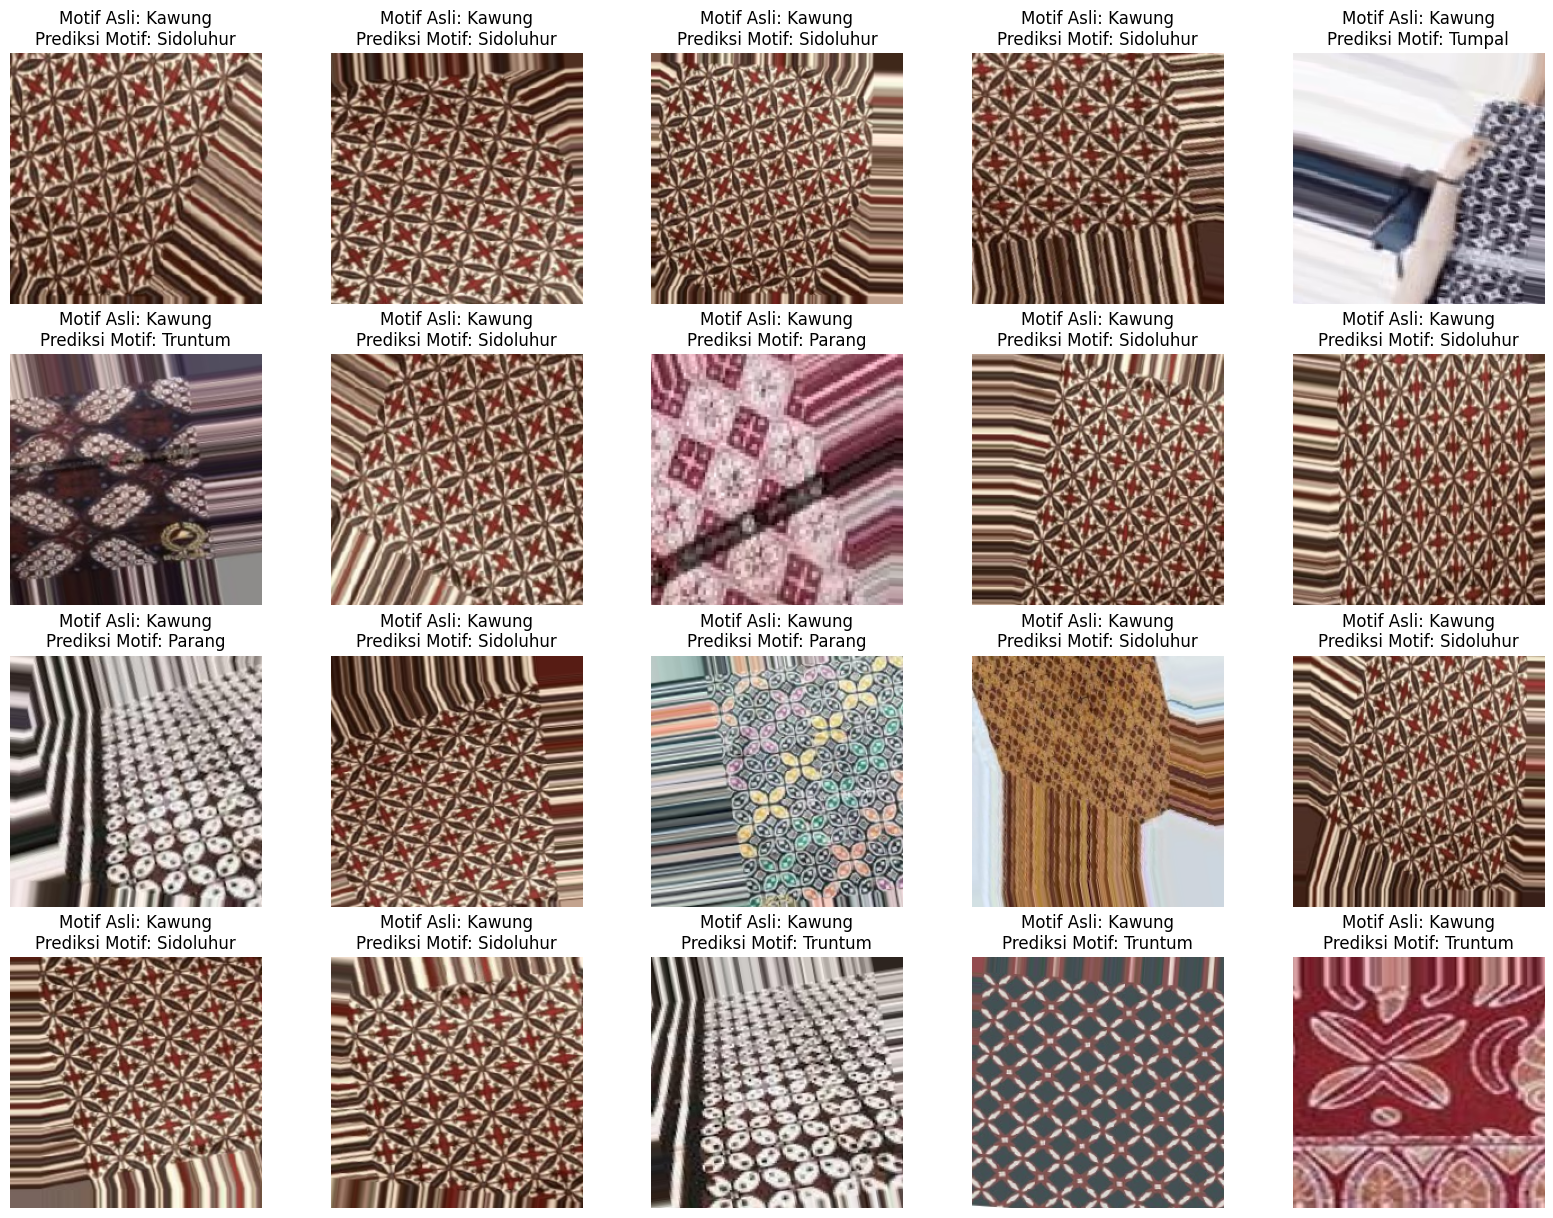

In [32]:
def show_wrong_predictions():
    # Ambil batch pertama dari val_generator
    x_test, y_test = get_all_batches(val_generator)
    
    # Buat mapping dari indeks ke nama kelas
    class_indices = val_generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Prediksi label untuk batch
    pred = model.predict(x_test)
    
    
    plt.figure(figsize=(20, 15))
    wrong_predictions = 0
    max_images = 20  # Maksimum gambar yang akan ditampilkan

    for i in range(len(x_test)):
        # Dapatkan label asli dan prediksi
        data_asli = idx_to_class[np.argmax(y_test[i])]
        prediksi_label = idx_to_class[np.argmax(pred[i])]

        # Cek jika prediksi salah
        if data_asli != prediksi_label:
            plt.subplot(4, 5, wrong_predictions + 1)
            plt.imshow(x_test[i])
            plt.title(f'Motif Asli: {data_asli}\nPrediksi Motif: {prediksi_label}')
            plt.axis('off')
            wrong_predictions += 1

        # Jika sudah 20 gambar yang ditampilkan, keluar dari loop
        if wrong_predictions >= max_images:
            break

    # Jika tidak ada prediksi yang salah
    if wrong_predictions == 0:
        print("Semua prediksi benar!")
    else:
        plt.show()

# Panggil fungsi untuk menampilkan prediksi salah
show_wrong_predictions()


5/5 [==============================] - 3s 375ms/step


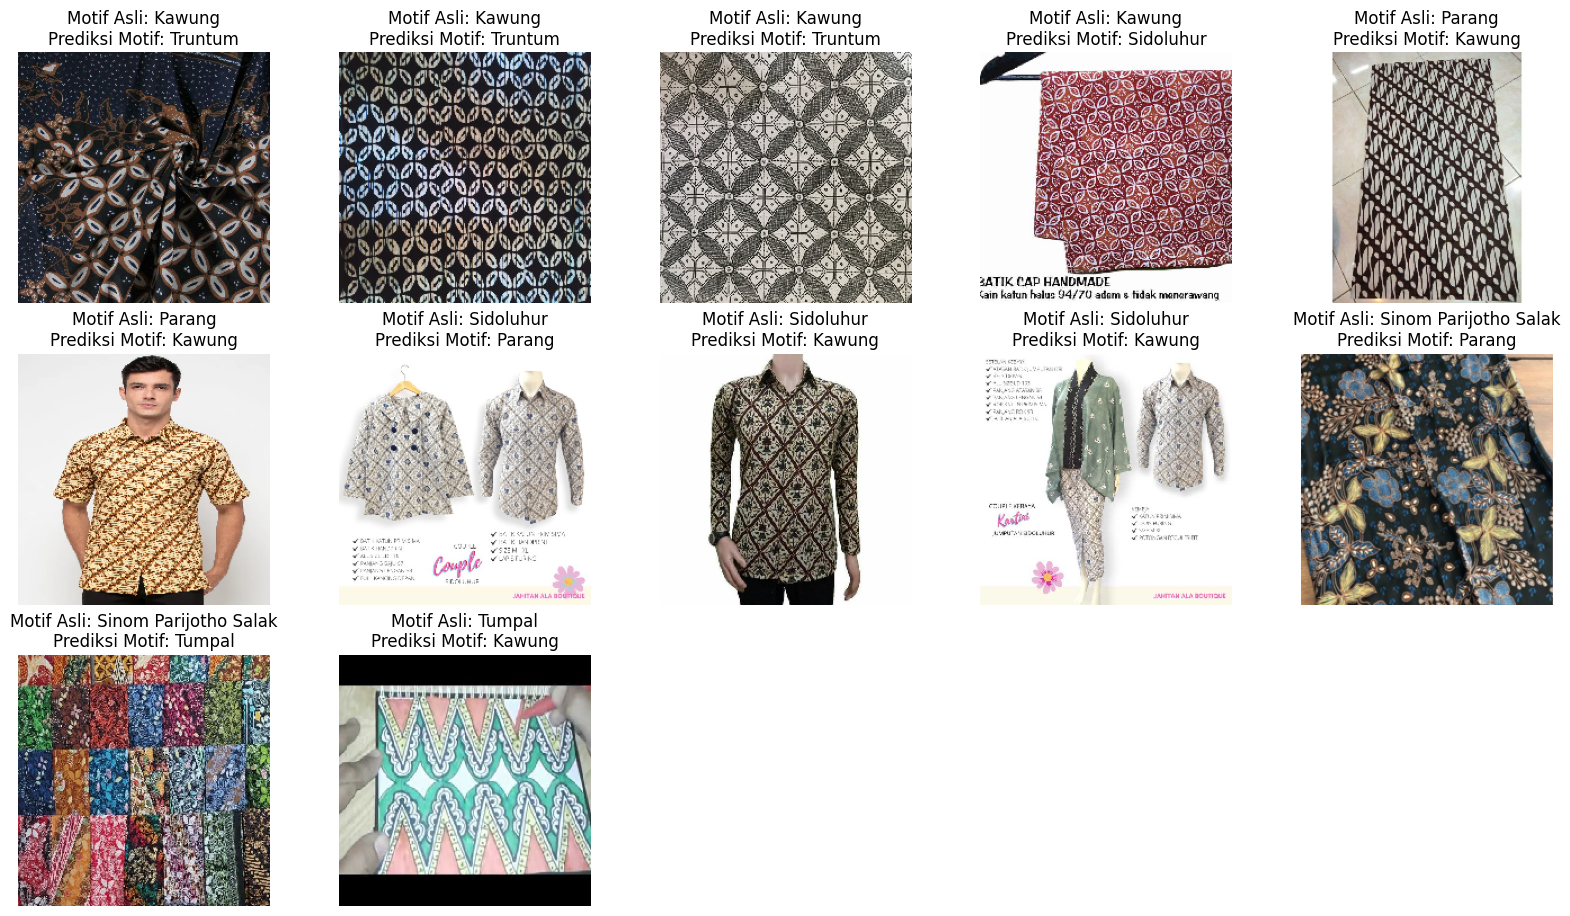

In [33]:
def get_all_batches(generator):
    x_all, y_all = [], []
    
    # Iterasi melalui generator
    for _ in range(len(generator)):  # Panjang generator menunjukkan jumlah batch
        x_batch, y_batch = next(generator)  # Ambil satu batch
        x_all.append(x_batch)  # Tambahkan gambar ke list
        y_all.append(y_batch)  # Tambahkan label ke list
    
    # Gabungkan semua batch menjadi array
    x_all = np.concatenate(x_all)
    y_all = np.concatenate(y_all)
    
    return x_all, y_all

# Pastikan shuffle=False untuk konsistensi
test_generator.shuffle = False

# Ambil seluruh batch dari test_generator
x_all, y_all = get_all_batches(test_generator)

def show_wrong_predictions():
    # Ambil batch pertama dari test_generator
    x_test, y_test = get_all_batches(test_generator)
    
    # Buat mapping dari indeks ke nama kelas
    class_indices = test_generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Prediksi label untuk batch
    pred = model.predict(x_test)
    
    plt.figure(figsize=(20, 15))
    wrong_predictions = 0
    max_images = 20  # Maksimum gambar yang akan ditampilkan

    for i in range(len(x_test)):
        # Dapatkan label asli dan prediksi
        data_asli = idx_to_class[np.argmax(y_test[i])]
        prediksi_label = idx_to_class[np.argmax(pred[i])]

        # Cek jika prediksi salah
        if data_asli != prediksi_label:
            plt.subplot(4, 5, wrong_predictions + 1)
            plt.imshow(x_test[i])
            plt.title(f'Motif Asli: {data_asli}\nPrediksi Motif: {prediksi_label}')
            plt.axis('off')
            wrong_predictions += 1

        # Jika sudah 20 gambar yang ditampilkan, keluar dari loop
        if wrong_predictions >= max_images:
            break

    # Jika tidak ada prediksi yang salah
    if wrong_predictions == 0:
        print("Semua prediksi benar!")
    else:
        plt.show()

# Panggil fungsi untuk menampilkan prediksi salah
show_wrong_predictions()


In [34]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

layer_name = 'Conv1'  # Ganti dengan nama layer yang ingin dilihat
layer_output = model.get_layer(layer_name).output

activation_model = Model(inputs=model.input, outputs=layer_output)

# Load gambar dan preprocess
img_path = 'Batik2/test/Sinom Parijotho Salak/Screenshot-from-2024-11-03-19-46-00_png.rf.625b617ffcd324d21fb64cf353d5e726.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Prediksi
activations = activation_model.predict(x)

# Pilih beberapa peta fitur untuk ditampilkan
n = 4  # Jumlah peta fitur yang akan ditampilkan
for i in range(n):
    plt.figure(figsize=(32, 4))
    for j in range(8):
        ax = plt.subplot(1, 8, j + 1)
        plt.imshow(activations[0, :, :, i * 8 + j], cmap='viridis')
        plt.axis('off')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Batik2/test/Sinom Parijotho Salak/Screenshot-from-2024-11-03-19-46-00_png.rf.625b617ffcd324d21fb64cf353d5e726.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


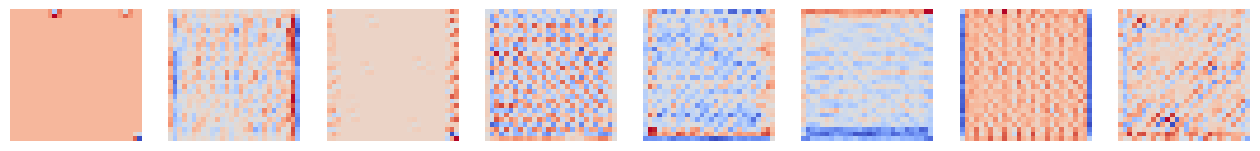

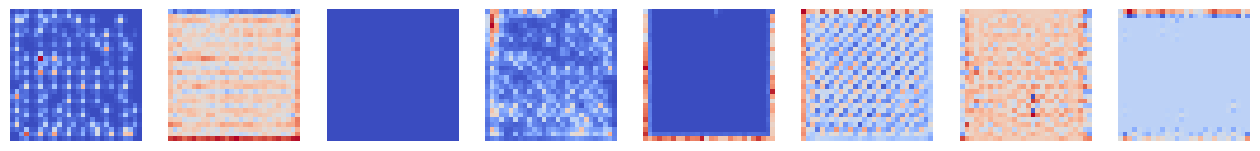

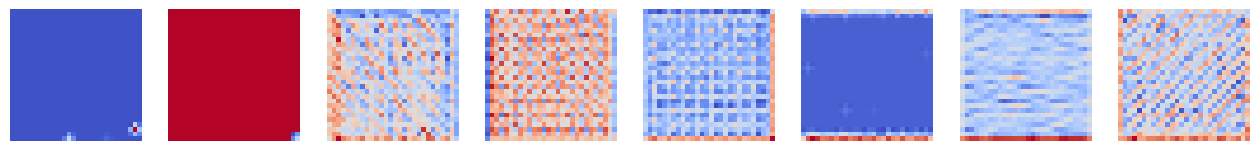

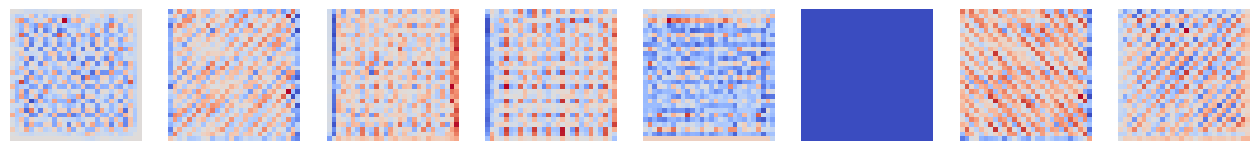

In [ ]:
layer_name = 'block_5_depthwise'  # Ganti dengan nama layer yang ingin dilihat
layer_output = model.get_layer(layer_name).output

activation_model = Model(inputs=model.input, outputs=layer_output)

# Load gambar dan preprocess
img_path = 'Batik Yogyakarta.v1i.folder/train/Kawung/kawung-24_jpg.rf.bf77678456ef9de9f04856edc2e4d9ad.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Prediksi
activations = activation_model.predict(x)

# Pilih beberapa peta fitur untuk ditampilkan
n = 4  # Jumlah peta fitur yang akan ditampilkan
for i in range(n):
    plt.figure(figsize=(16, 4))
    for j in range(8):
        ax = plt.subplot(1, 8, j + 1)
        plt.imshow(activations[0, :, :, i * 8 + j], cmap='coolwarm')
        plt.axis('off')
    plt.show()

In [ ]:
train_generator.class_indices

{'Kawung': 0,
 'Parang': 1,
 'Parijotho Salak Sinom': 2,
 'Sidoluhur': 3,
 'Truntum': 4}

1/1 [==============================] - 0s 51ms/step


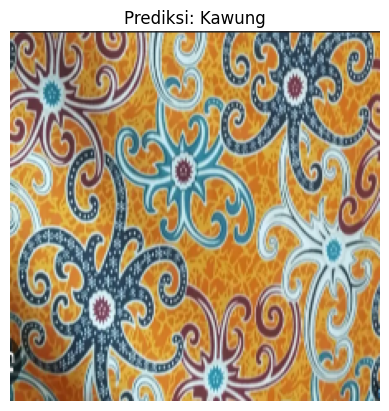

Insang: 0.00
Kawung: 1.00
Mega mendung: 0.00
Parang: 0.00
Sidoluhur: 0.00
Sinom Parijotho Salak: 0.00
Truntum: 0.00
Tumpal: 0.00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Fungsi untuk membaca gambar dan preprocess
def load_image(image_path, target_size=(224, 224)):
    # Baca gambar menggunakan OpenCV
    img = cv2.imread(image_path)
    # Ubah BGR ke RGB (karena OpenCV membaca gambar dalam format BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize gambar sesuai dengan input model
    img = cv2.resize(img, target_size)
    # Normalisasi piksel (sesuaikan dengan preprocessing saat pelatihan)
    img = img / 255.0
    # Tambahkan dimensi untuk batch
    img = np.expand_dims(img, axis=0)
    return img

# Load model
model = model

# Ganti dengan filepath gambar yang ingin diprediksi
image_path = 'Screenshot 2025-01-06 101159.png
'
# Load gambar dan preprocess
image = load_image(image_path)

# Lakukan prediksi
predictions = model.predict(image)

# Ambil kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions)

# Dapatkan nama kelas (sesuaikan dengan dataset Anda)
class_indices = val_generator.class_indices
classes = list(class_indices.keys())  # Ambil nama kelas dalam urutan yang benar

# Tampilkan gambar dan prediksi
plt.imshow(image[0])
plt.title("Prediksi: " + classes[predicted_class])
plt.axis('off')
plt.show()

# Tampilkan probabilitas untuk setiap kelas
for i in range(len(classes)):
    print(f"{classes[i]}: {predictions[0][i]:.2f}")

In [ ]:
predictions

array([[1.5008748e-29, 1.0291021e-07, 1.2261539e-33, 9.9999988e-01,
        1.3784703e-26, 1.3917185e-38, 5.6074780e-09, 0.0000000e+00]],
      dtype=float32)

In [ ]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ... (asumsikan model sudah didefinisikan dan dikompilasi)

img_path = 'Batik2/2024_gmc_hummer_ev_pickup_rear_4k-3840x2160.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Prediksi gambar
predictions = model.predict(x)

class_indices = val_generator.class_indices
classes = list(class_indices.keys())  # Ambil nama kelas dalam urutan yang benar
predicted_class = classes[np.argmax(predictions)]
print(f'Prediksi: {predicted_class}')

# Tampilkan semua probabilitas beserta nama kelasnya
for i, prob in enumerate(predictions[0]):
    print(f"Probabilitas kelas {classes[i]}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediksi: Truntum
Probabilitas kelas Insang: 0.01
Probabilitas kelas Kawung: 0.00
Probabilitas kelas Mega mendung: 0.00
Probabilitas kelas Parang: 0.01
Probabilitas kelas Sidoluhur: 0.00
Probabilitas kelas Sinom Parijotho Salak: 0.00
Probabilitas kelas Truntum: 0.98
Probabilitas kelas Tumpal: 0.00


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import numpy as np

# Mendapatkan batch data dari val_generator
x_test, y_test = test_generator.
# Membuat dictionary untuk inverse class indices
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Mendapatkan prediksi dari model
pred = model.predict(val_generator)

# Fungsi untuk menampilkan gambar dan prediksinya
def show_predictions(gambar):
    plt.figure(figsize=(5, 5))
    plt.imshow(x_test[gambar])  # Menampilkan gambar
    data_asli = idx_to_class[np.argmax(y_test[gambar])]  # Label asli
    prediksi_label = idx_to_class[np.argmax(pred[gambar])]  # Prediksi label
    plt.title(f'Motif Asli: {data_asli}\nPrediksi Motif: {prediksi_label}')
    plt.axis('off')
    plt.show()

# Membuat slider interaktif
interact(show_predictions, gambar=widgets.IntSlider(min=0, max=len(x_test) - 1, step=1, value=0))


SyntaxError: invalid syntax (1723347311.py, line 6)